> Copyright (c) 2023 Massachusetts Institute of Technology  
> SPDX-License-Identifier: MIT 


# Generating Adversarial Perturbations

Solving for adversarial perturbations is a common task in Robust AI. An adversarial perturbation for a given input, $x$, with corresponding label, $y$, can be computed by solving the following optimization objective:

$$\max_{||\delta||_p<\epsilon} \mathcal{L}\left(f_\theta(x+\delta), y\right) $$

where $\delta$ is the perturbation, $f_\theta$ is a machine learning model parameterized by $\theta$, $\mathcal{L}$ is the loss function (e.g., cross-entropy), $||\delta||_p$ is the $L^p$-norm of the perturbation (for this example we'll be using $p=2$), and $\epsilon$ is the maximum allowable size of the perturbation.

This tutorial demonstrates how to use [rai_toolbox.perturbations.gradient_ascent](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.perturbations.gradient_ascent.html#rai_toolbox.perturbations.gradient_ascent) to generate $L^2$-norm-constrained adversarial perturbations using projected gradient descent (PGD) for images from the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, based on both a standard classification model and a robust (i.e., adversarially-trained) model. 
We then compute adversarial accuracy for a few batches of samples from the test set, and use this to generate robustness curves for increasing values of perturbation size, $\epsilon$.



## Getting Started


We will install the rAI-toolbox and then we will create a Jupyter notebook in which we will complete this tutorial.


### Installing `rai_toolbox`
To install the toolbox (along with its `mushin` capabilities) in your Python environment, run the following command in your terminal:

```console
$ pip install rai-toolbox[mushin]
```

To verify that the toolbox is installed as expected, open a Python console and try 
importing `rai_toolbox`.

```console
$ python
```
```python
>>> import rai_toolbox
```
If no errors are returned, `rai_toolbox` is successfully installed.


### Installing `rai_experiments`
This tutorial also requires the installation of the `rai_experiments` library:

```console
$ pip install rai-experiments
```

To verify the `rai_experiments` library is installed as expected, open a Python console and try 
importing `rai_experiments`.

```console
$ python
```
```python
>>> import rai_experiments
```
If no errors are returned, `rai_experiments` is successfully installed.


### Installing `ipywidgets`
You may also need to install the `ipywidgets` package in your Python environment to configure the Jupyter notebook to  display ipywidgets:

```console
$ pip install ipywidgets
```

To verify the `ipywidgets` library is installed as expected, open a Python console and try 
importing `ipywidgets`.

```console
$ python
```
```python
>>> import ipywidgets
```
If no errors are returned, `ipywidgets` is successfully installed.

## Opening a Jupyter notebook

If you do not have Jupyter Notebook or Jupyter Lab installed in your Python environment, please follow [these instructions](https://docs.jupyter.org/en/latest/install/notebook-classic.html).

After installation, open a terminal on your computer and [start a notebook/lab session](https://docs.jupyter.org/en/latest/running.html).

A file-viewer will open in an internet browser. Pick a directory where you are okay with saving some PyTorch model weights. Create a notebook called `CIFAR10-Adversarial-Perturbations.ipynb`. 

You can then follow along with this tutorial by copying, pasting, and running the code blocks below in the cells of your notebook.

## Boilerplate setup
In the notebook, we will start by importing modules from the toolbox and 3rd party libraries needed for this tutorial. Then we will specify directories where data and models will be stored,  and determine if computations will be run on CPU or GPU (depending on the resources available on your machine).

In [1]:
from functools import partial
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
import torchvision

from rai_toolbox.perturbations import gradient_ascent, AdditivePerturbation
from rai_toolbox.optim import L2ProjectedOptim

In [2]:
DATA_DIR = str(Path.home() / ".torch" / "data")
MODEL_DIR = str(Path.home() / ".torch" / "model")

In [3]:
# CPU or GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


We will also define a function for plotting images:

In [4]:
def plot_images(x, y, class_names, x_adv=None, y_adv=None):
    if x_adv is not None:
        fig, ax = plt.subplots(3, 10, figsize=(20, 5))
    else:
        fig, ax = plt.subplots(1, 10, figsize=(20, 5))

    for i in range(10):
        if x_adv is not None:
            ax[0, i].imshow(x[i].permute(1, 2, 0))
            ax[0, i].set_title(class_names[y[i]])
            ax[0, i].axis("off")
            ax[1, i].imshow(x_adv[i].detach().cpu().permute(1, 2, 0))
            if y_adv[i].item() != y[i].item():
                ax[1, i].set_title(class_names[y_adv[i]], color="r")
            else:
                ax[1, i].set_title(class_names[y_adv[i]], color="k")
            ax[1, i].axis("off")
            ax[2, i].imshow(
                (torch.abs(x[i] - x_adv[i].detach().cpu()) * 25)
                .clamp_(0, 1)
                .permute(1, 2, 0)
            )
            ax[2, i].axis("off")
        else:
            ax[i].imshow(x[i].permute(1, 2, 0))
            ax[i].set_title(class_names[y[i]])
            ax[i].axis("off")


## Loading the CIFAR-10 dataset

CIFAR-10 is a dataset containing 32x32 RGB images; each image depicts an object or animal belonging to one of ten classes. Here we will load images from the test set and plot a few example images from each class.

In [5]:
BATCH_SIZE = 10

# Load CIFAR10 test dataset
dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
print(f"Number of Test Samples: {len(dataset)}")

# Grab class names
class_names = dataset.classes
print(f"Classes: {class_names}")

# Instantiate a data loader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting C:\Users\Ryan Soklaski\.torch\data\cifar-10-python.tar.gz to C:\Users\Ryan Soklaski\.torch\data
Number of Test Samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


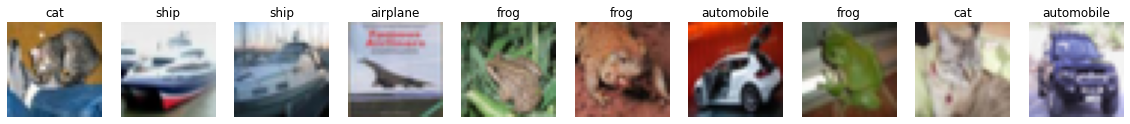

In [6]:
# Sample first batch of test data and plot
x, y = next(iter(dataloader))
plot_images(x, y, class_names)

## Loading pre-trained CIFAR-10 models

Next we will define two models:
1. `model_robust` is a classification model that was trained against adversarially-generated training data. 
2. `model_standard` is a classification model that was trained against CIFAR-10 using standard (i.e., non-adversarial) data augmentation procedures. 

The weights for both models are derived from Madrylab's [robustness](https://github.com/MadryLab/robustness) library:

We will use two pre-trained models for these definitions:
1. `mitll_cifar_l2_1_0.pt`: A simplified data structure of the pre-trained model available via the [mit-ll-responsible-ai/data_hosting repo](https://github.com/mit-ll-responsible-ai/data_hosting/releases/download/madrylab_models/mitll_cifar_l2_1_0.pt). This is a ResNet-50 model trained with perturbations generated via PGD using perturbations constrained to $L^2$-ball of radius $\epsilon=1.0$
2. `mitll_cifar_nat.pt`: A simplified data structure of the pre-trained model available via the [mit-ll-responsible-ai/data_hosting repo](https://github.com/mit-ll-responsible-ai/data_hosting/releases/download/madrylab_models/mitll_cifar_nat.pt). This is a ResNet-50 model trained using standard training with no adversarial perturbations in the loop (i.e., $\epsilon=0$)

`rai_experiments.models.pretrained.load_model` will automatically download and cache pre-trained weights for these models.

In [8]:
from rai_experiments.models.pretrained import load_model

In [9]:
# Load pre-trained model that was trained using a robust approach (i.e., adversarial training)
ckpt_robust = "mitll_cifar_l2_1_0.pt"
model_robust = load_model(ckpt_robust)
model_robust.eval();

# Load pre-trained model that was trained with standard approach
ckpt_standard = "mitll_cifar_nat.pt"
model_standard = load_model(ckpt_standard)
model_standard.eval();

## Obtaining adversarial perturbations for a batch of data

Now we will use the [gradient_ascent](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.perturbations.gradient_ascent.html) function with an [AdditivePerturbation](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.perturbations.AdditivePerturbation.html) model and [L2ProjectedOptim](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.optim.L2ProjectedOptim.html) optimizer from the toolbox to solve for $L^2$-norm-constrained adversarial perturbations to samples from the dataset. These are perturbations that maximize – within the given constraints – the cross-entropy classification loss measured on our model's predictions.

`AdditivePerturbation` implements $x_{adv}=x+\delta$, where $\delta$ is the sole trainable parameter of the perturbation model.

We will use `functools.partial` to set default values for `gradient_ascent`, so that they can be used consistently across our two models.

In [10]:
# Define perturbation model
perturbation_model = AdditivePerturbation(x.shape)

# Define parameters for perturbation optimizer
EPS = 0.5  # L2-norm of perturbation
STEPS = 10  # number of gradient steps during perturbation optimization
FACTOR = 2.5  # factor for determining step size (learning rate)

# Function for selecting step size (learning rate) for perturbation optimizer
def get_stepsize(factor: float, steps: int, epsilon: float) -> float:
    return factor * epsilon / steps

# Define perturbation solver that we will apply to multiple models.
# Fills out all params for `gradient_ascent` except `data`, `target`, and `model`.
# Signature: solver(data: Tensor, target: Tensor, model: nn.Module)
solver = partial(
    gradient_ascent,
    perturbation_model = perturbation_model.to(device),
    optimizer=L2ProjectedOptim,
    lr=get_stepsize(FACTOR, STEPS, EPS),
    epsilon=EPS,
    steps=STEPS,
    targeted=False,
    use_best=True,
)

We will first solve for a single batch of adversarial perturbations for our standard model.
Given a batch of images, this will produce a corresponding batch of perturbed images and we will plot each image, perturbed image, and the corresponding perturbation that we solved for, which attempts to "fool" the standard model.  

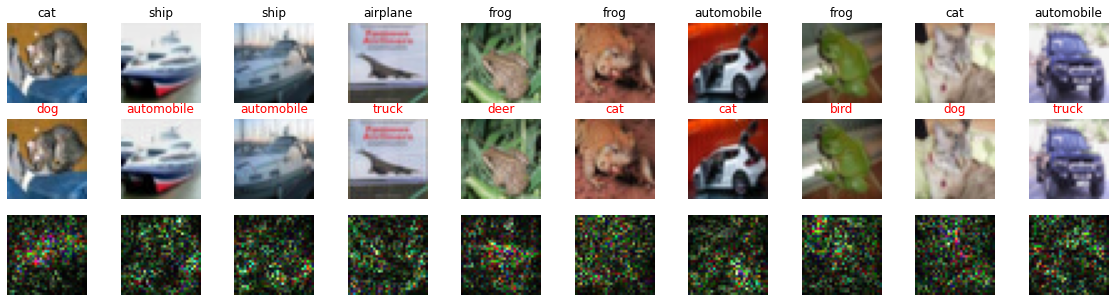

In [11]:
# Solve for adversarial perturbations to standard model and plot
x_adv, loss_adv = solver(
    data=x.to(device),
    target=y.to(device),
    model=model_standard.to(device)
)

# Compute predictions for adversarial samples
x_adv = x_adv.clamp_(0, 1)
logits_adv = model_standard(x_adv)
y_adv = torch.argmax(logits_adv, axis=1)

# Plot original and adversarial samples
plot_images(x, y, class_names, x_adv, y_adv)

The top row is the original image with true label, the second row is the adversarially-perturbed image with the label predicted by the model, and the third row is the perturbation (multiplied by $25$ so it can be viewed more easily).

Now we now use the same batch of data to produce adversarial examples for our robust model.

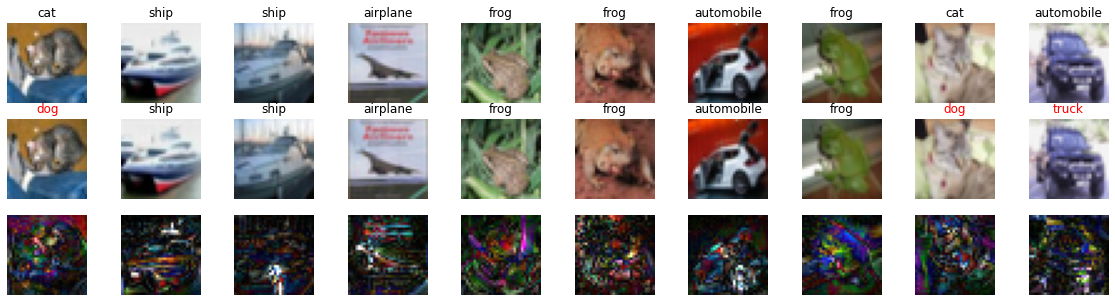

In [12]:
# Repeat for robust model
x_adv, loss_adv = solver(
    data=x.to(device),
    target=y.to(device),
    model=model_robust.to(device)
)

# Compute predictions for adversarial samples
x_adv = x_adv.clamp_(0, 1)
logits_adv = model_robust(x_adv)
y_adv = torch.argmax(logits_adv, axis=1)

# Plot original and adversarial samples
plot_images(x, y, class_names, x_adv, y_adv)

Note that the robust model is making fewer mistakes on the adversarially-perturbed images, and its perturbations also appear to contain more structure.

## Computing adversarial accuracy over multiple batches

Finally, we'll compute adversarial accuracy (i.e., accuracy of the model on adversarially-perturbed images) across multiple batches of validation data, and for increasing values of perturbation size, $\epsilon$, to generate robustness curves and visualize how quickly performance drops off for each of the models.

Here we define our own function for iterating over batches and computing accuracy, but note that this can easily been integrated with [PyTorch Lightning's](https://www.pytorchlightning.ai/) framework to save us from writing such boilerplate code.

In [13]:
# Define function for computing adversarial perturbations and adversarial accuracy over multiple batches
def compute_adversarial_accuracy(model, dataloader, epsilons, num_batches, device):
    accuracies = []

    model = model.to(device)
    for EPS in epsilons:
        print(f"Epsilon = {EPS}")

        # solver(data: Tensor, target: Tensor) 
        solver = partial(
            gradient_ascent,
            model=model,
            optimizer=L2ProjectedOptim,
            lr=get_stepsize(FACTOR, STEPS, EPS),
            epsilon=EPS,
            steps=STEPS,
            targeted=False,
            use_best=True,
        )

        data_iter = iter(dataloader)
        accur = 0.0
        for i in tqdm(range(num_batches)):
            # Sample next batch
            x, y = next(data_iter)

            # Solve for perturbation
            x_adv, _ = solver(data=x.to(device), target=y.to(device))

            # Compute accuracy
            x_adv = x_adv.clamp_(0, 1)
            logits_adv = model(x_adv)
            y_adv = torch.argmax(logits_adv, axis=1).detach().cpu()
            accur += sum(y == y_adv) / len(x)

        accuracies.append(accur / num_batches)
    return accuracies

Compute adversarial accuracy for both models using 10 batches of data and multiple values of epsilon

In [14]:
# Compute adversarial accuracy of both models for multiple values of epsilon
num_batches = 10
epsilons = [0, 0.25, 0.5, 1, 2]

In [15]:
# Compute adversarial accuracy for standard model
accuracies_standard = compute_adversarial_accuracy(
    model_standard,
    dataloader,
    epsilons,
    num_batches,
    device=device,
)

Epsilon = 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Epsilon = 0.25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Epsilon = 0.5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Epsilon = 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Epsilon = 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


In [16]:
# Compute adversarial accuracy for robust model
accuracies_robust = compute_adversarial_accuracy(
    model_robust,
    dataloader,
    epsilons,
    num_batches,
    device=device,
)

Epsilon = 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Epsilon = 0.25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


Epsilon = 0.5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Epsilon = 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Epsilon = 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


Plot the results:

(0.0, 1.0)

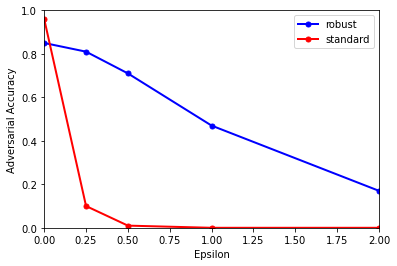

In [17]:
# Plot robustness curves
plt.plot(epsilons, accuracies_robust, linewidth=2, marker=".", markersize=10, color="b", label="robust")
plt.plot(epsilons, accuracies_standard, linewidth=2, marker=".", markersize=10, color="r", label="standard")
plt.xlabel("Epsilon")
plt.ylabel("Adversarial Accuracy")
plt.legend()
plt.xlim([0, 2])
plt.ylim([0, 1])

While the standard model is the most accurate on unperturbed data ($\epsilon=0$), it is reduced to near-guessing performance by the smallest-magnitude adversarial perturbations. By contrast, the robust model's performance decays much more gradually in light of perturbations of increasing strength.

In the next tutorial, we will see how we can use the same ``gradient_ascent`` solver and ``AdditivePerturbation`` model with a different optimizer to execute a task from Explainable AI called concept probing.